In [1]:
!pip install -q transformers nltk tensorflow tensorflow-hub tensorflow_text

## Import libraries

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
df_train = pd.read_csv("/kaggle/input/data-hackaton/test.csv")
df_train

,text,label,src
0,Little disclaimer: this deals with US laws and...,1,cmv_human
1,"Read: Mentally Retarded Downs. See, we've got ...",1,cmv_human
2,"If any of you frequent rbadhistory, there is a...",1,cmv_human
3,"I believe in a flat tax system, where everyone...",1,cmv_human
4,"Edit: Ok guy's, my views have been changed on ...",1,cmv_human
...,...,...,...
56814,We consider the recovery of a source term f (x...,1,sci_gen_human
56815,"Self-supervised learning (SlfSL), aiming at le...",1,sci_gen_human
56816,Recurrent neural networks (RNNs) have achieved...,1,sci_gen_human
56817,Deep reinforcement learning (DRL) is a booming...,1,sci_gen_human


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56819 entries, 0 to 56818
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    56819 non-null  object
 1   label   56819 non-null  int64 
 2   src     56819 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [8]:
df_train['text'].value_counts()

text
Little disclaimer: this deals with US laws and procedures so I apologize if anyone outside the US isn't able to contribute, except to tell me how great it is having this in their own country. Last Sunday John Oliver's show dealt with this subject and chastised the US for being only one of two developed countries in the world without maternity leave that is paid for by the taxpayers. Here is a link to watch it if you haven't seen it yet: Here is the gist of my viewpoint: In the US, when a person is terminated from a job, heshe is entitled to unemployment benefits for up to 99 weeks or until they are employed again. Workers and companies pay into this and, while many people end up taking more than they give, it is the system we have and it seems to work for the majority of people here. When a person leaves a job VOLUNTARILY, however, they are not entitled to unemployment benefits. If you quit a job to go to another job this is fine. If you are quitting to go'find' yourself in Austra

## Average Len

In [10]:
df_train["text_len"] = df_train["text"].apply(lambda x : len(x.split()))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


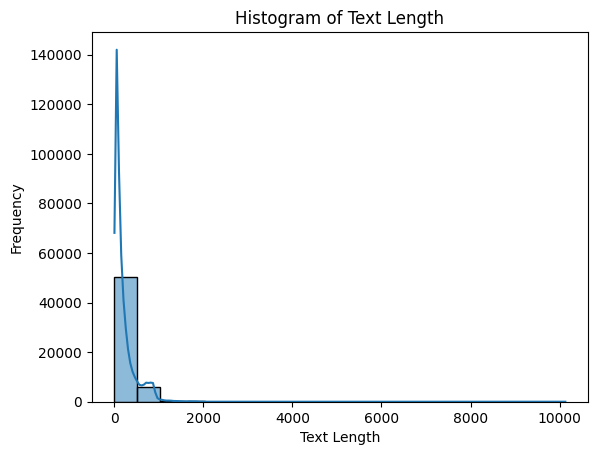

In [11]:
sns.histplot(df_train['text_len'], bins=20, kde=True)
plt.title('Histogram of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [12]:
print(df_train["text_len"].mean())
print(df_train["text_len"].max())

212.43703690666854
10129


Since the average seq len is 377. Then, it is enough to use bert with 512 seq len

## Data pre-process

In [13]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download the stopwords dataset (you can move this line to the main part of your code if you prefer)
# nltk.download('stopwords')
# nltk.download('punkt')

def remove_stopwords(input_text, language='english'):
    """
    Remove stopwords from the input text.

    Parameters:
    - input_text (str): The input text containing stopwords.
    - language (str): The language of the stopwords. Default is 'english'.

    Returns:
    - str: The cleaned text without stopwords.
    """
    # Tokenize the text
    words = word_tokenize(input_text['text'])
    
    print(f"Index {input_text['index_col']}") if input_text['index_col'] % 10000 == 0 else None

    # Remove stopwords
    filtered_words = [word for word in words if word.lower() not in stopwords.words(language)]

    # Join the filtered words to form the cleaned text
    cleaned_text = ' '.join(filtered_words)

    return cleaned_text

In [ ]:
# df_balanced_train['index_col'] = df_balanced_train.index
# df_balanced_train["text"] = df_balanced_train.apply(lambda text: remove_stopwords(text), axis=1)

# df_test_essay['index_col'] = df_test_essay.index
# df_test_essay["text"] = df_test_essay.apply(lambda text: remove_stopwords(text), axis=1)

### Split

In [14]:
from sklearn.model_selection import train_test_split

x, y = df_train['text'], df_train['label']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=69420)


# Model

In [15]:
# Import libraries
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub


In [16]:
model_path = "/kaggle/input/bert/tensorflow2/bert-en-uncased-l-12-h-128-a-2/2"
preprocess_path = "/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/"

In [17]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(preprocess_path)
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    model_path,
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 512].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 512].
dense_1 = tf.keras.layers.Dense(128 , activation='relu')(pooled_output)
dropout = tf.keras.layers.Dropout(0.7 , name="dropout1")(pooled_output)
dense_2 = tf.keras.layers.Dense(64 , activation='relu')(dropout)
dropout = tf.keras.layers.Dropout(0.5 , name="dropout2")(dense_2)

dense_out = tf.keras.layers.Dense(1 , activation='sigmoid', name='output')(dropout)


model = tf.keras.Model(inputs=text_input, outputs=dense_out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['input_1[0][0]']             
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [19]:
# https://huggingface.co/google/bert_uncased_L-12_H-128_A-2
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss='binary_crossentropy',
              metrics=["acc"])

checkpoint_filepath = 'checkpoint.hdf5'
metric = 'val_accuracy'
callback_list = [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                    monitor=metric,
                                                    verbose=2,
                                                    save_best_only=True,
                                                    mode='max'), 
                 tf.keras.callbacks.EarlyStopping(monitor=metric,
                                                  patience=0,
                                                  restore_best_weights=True)
                ]
history = model.fit(x_train, y_train , batch_size=8, callbacks=[callback_list],
                    epochs=2 , validation_data=(x_test, y_test))
# model.load_weights(checkpoint_filepath)
model.save("model-bert")

Epoch 1/5
5682/5682 [==============================] - 447s 72ms/step - loss: 0.6508 - acc: 0.6089 - val_loss: 0.5086 - val_acc: 0.7995
Epoch 2/5
5682/5682 [==============================] - 357s 63ms/step - loss: 0.2944 - acc: 0.8861 - val_loss: 0.2183 - val_acc: 0.9280
Epoch 3/5
5682/5682 [==============================] - 350s 62ms/step - loss: 0.1711 - acc: 0.9414 - val_loss: 0.1906 - val_acc: 0.9313
Epoch 4/5
5682/5682 [==============================] - 339s 60ms/step - loss: 0.1184 - acc: 0.9605 - val_loss: 0.2473 - val_acc: 0.9282
Epoch 5/5
5682/5682 [==============================] - 348s 61ms/step - loss: 0.0924 - acc: 0.9702 - val_loss: 0.2055 - val_acc: 0.9395


# Test

In [20]:
loss , acc = model.evaluate(x_train, y_train)
print("Accuracy on Train data:",acc)
loss , acc = model.evaluate(x_test, y_test)
print("Accuracy on Test data:",acc)

1421/1421 [==============================] - 116s 82ms/step - loss: 0.0384 - acc: 0.9857
Accuracy on Train data: 0.9856781363487244
356/356 [==============================] - 29s 80ms/step - loss: 0.2055 - acc: 0.9395
Accuracy on Test data: 0.9394579529762268


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, r2_score
from sklearn.linear_model import LogisticRegression

In [26]:
y_pred_test = model.predict(x_test)

356/356 [==============================] - 28s 77ms/step


In [25]:
print("R2 Score: ", r2_score(y_test, y_pred_test))

R2 Score:  0.804639581321006


In [29]:
#Seconde étude des performances du modèle en utilisant une matrice de confusion
"""cm = confusion_matrix(y_test, y_pred_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['IA', 'Humain'])
disp.plot()
plt.show()"""

"cm = confusion_matrix(y_test, y_pred_test, labels=[0,1])\ndisp = ConfusionMatrixDisplay(confusion_matrix=cm,\n                               display_labels=['IA', 'Humain'])\ndisp.plot()\nplt.show()"

In [30]:
!ls /kaggle/working

model-bert
